<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/TimeSeries/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, first the detection and visualization of data anomaly for
timeseries is are discussed. Then I show a simple method to make the impcat of data on the analysis minimum. 

<br><br>
---

Written by: Arjang Fahim <br>
Date: 11/6/2021 <br>
Last update: 11/6/2021

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#**Catfish Sales Data**

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [5]:
#read data
catfish_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TimeSeries/data/catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [6]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [7]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [8]:
#At December 1 1998
# Here we artificially introduce an anomaly 
lim_catfish_sales[datetime(1998,12,1)] = 10000

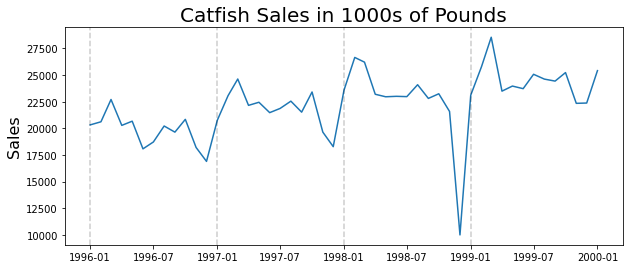

In [9]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In anove plot, there is a seasonality and SARIMA is built for this data, to predict the last 6 month given the pas three and half years

# **Remove the trend**

In [10]:
first_diff = lim_catfish_sales.diff()[1:]

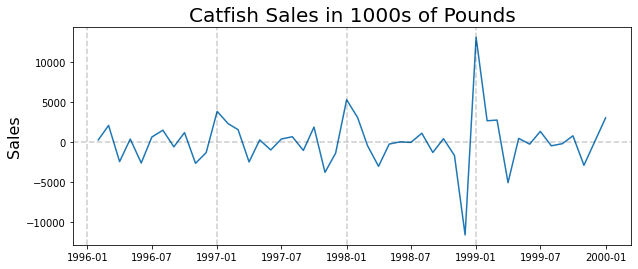

In [11]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# **Get training and testing sets**

In [12]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# **Make Predictions**

In [13]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [14]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [15]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

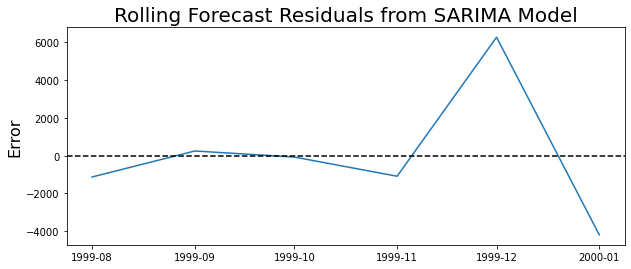

In [16]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

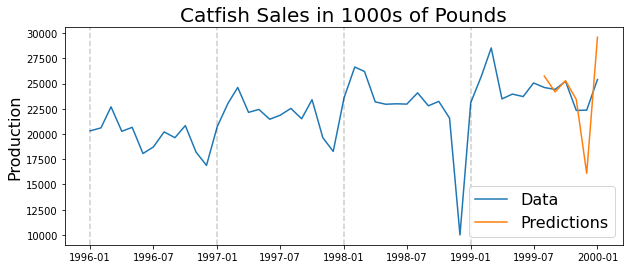

In [17]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0921


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3144.3795890445545


# **Detecting the Anomaly**

# **Attempt 1: Deviation Method**

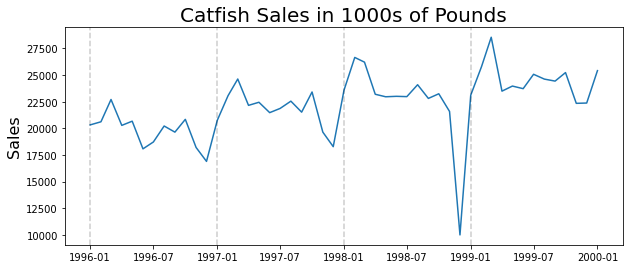

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [22]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [23]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [24]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

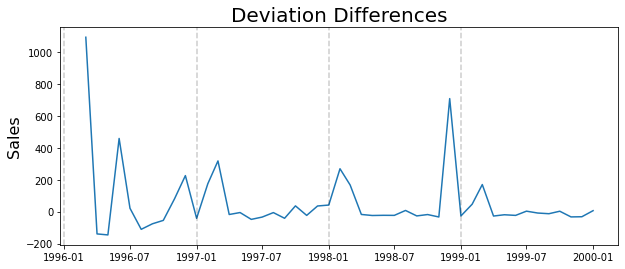

In [25]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# **Attempt 2: Seasonal Method**

In [26]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

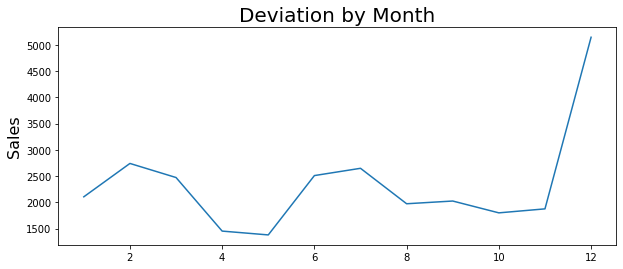

In [27]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

# **So, the anomaly occurs in a December**

In [28]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [29]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [30]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [31]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

# **What to do about the anomaly?**

## **Simple Idea: use mean of other months**

In [32]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

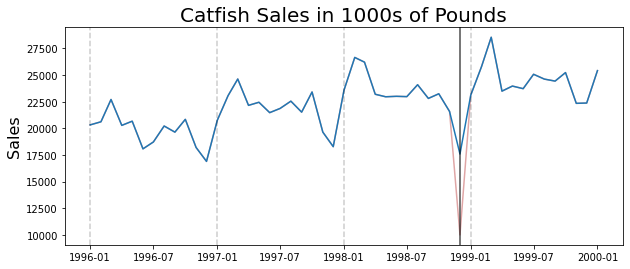

In [33]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# **Resulting Predictions**

In [34]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [35]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [36]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

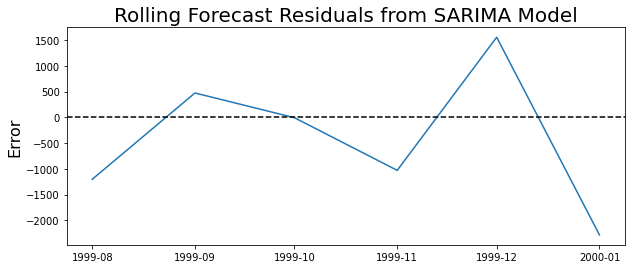

In [37]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

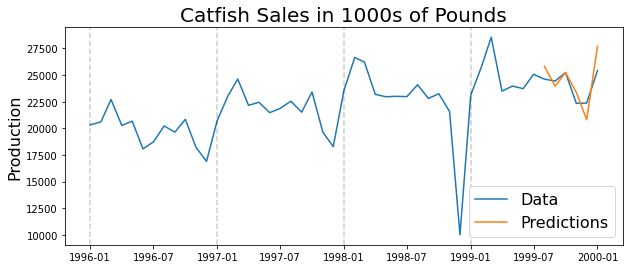

In [38]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [39]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0457


In [40]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1314.793139623112
